In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


### Getting the data ready

In [2]:
data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [3]:
dataset = datasets.ImageFolder(root='data', transform=data_transforms)

In [4]:
dataset

Dataset ImageFolder
    Number of datapoints: 4600
    Root location: data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - val_size - train_size

(test_size/dataset_size, val_size/dataset_size, train_size/dataset_size)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

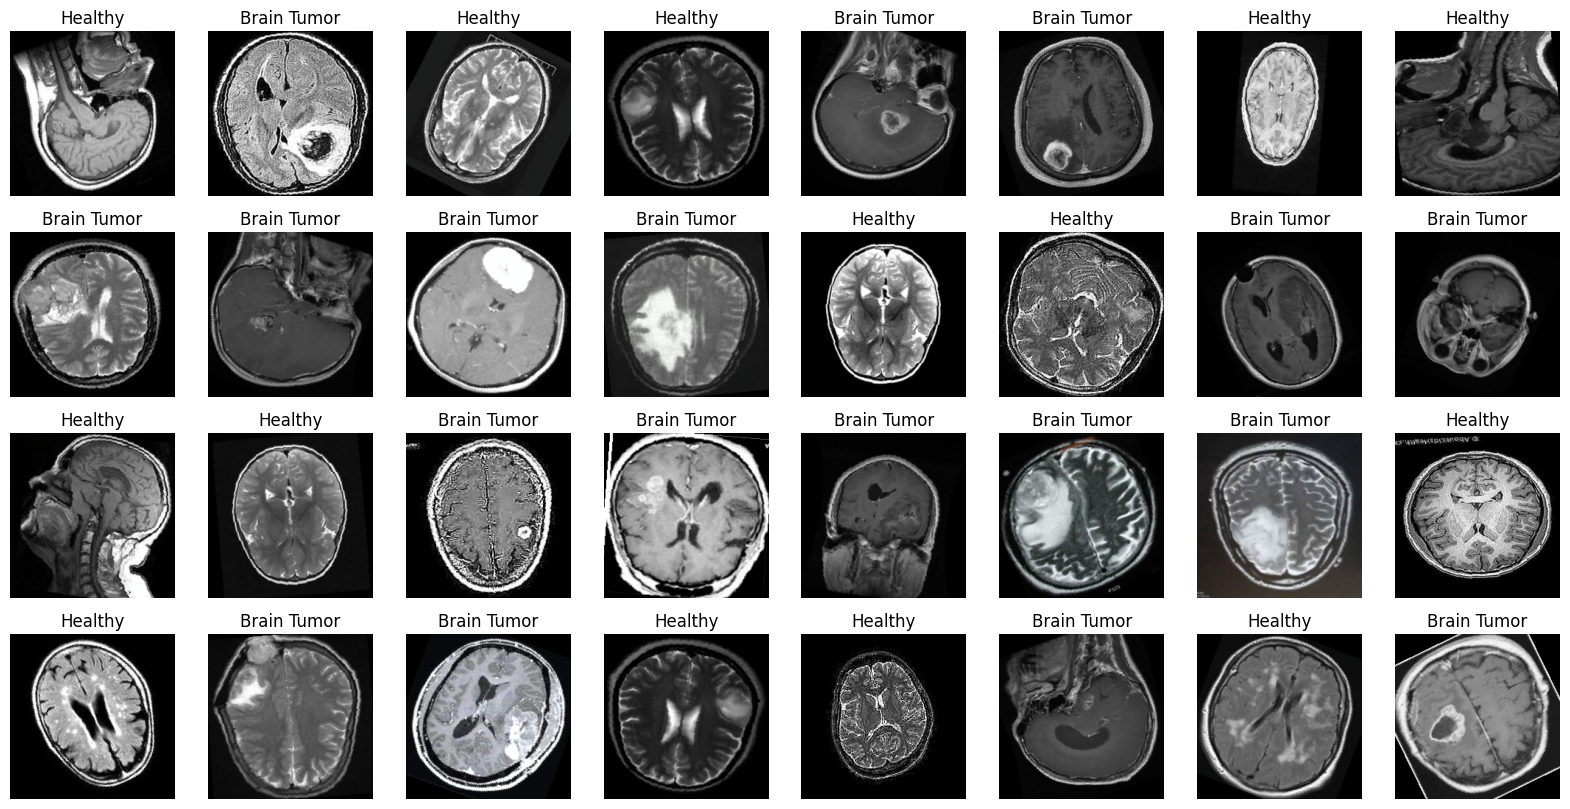

In [7]:
def imshow_with_labels(inputs, classes, class_names):
    """Imshow for Tensor with labels."""
    # Unnormalize the images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    batch_size = inputs.size(0)
    fig, axes = plt.subplots(4, 8, figsize=(20, 10))
    axes = axes.flatten()
    
    for i in range(batch_size):
        inp = inputs[i].numpy().transpose((1, 2, 0))
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        
        ax = axes[i]
        ax.imshow(inp)
        ax.set_title(class_names[classes[i]])
        ax.axis('off')
        
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(train_loader))
class_names = dataset.classes

# Make a grid from batch
imshow_with_labels(inputs, classes, class_names)

### Instatiating the model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
vgg16 = models.vgg16(pretrained=True)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /teamspace/studios/this_studio/.cache/torch/hub/checkpoints/vgg16-397923af.pth
 13%|█▎        | 69.0M/528M [00:00<00:03, 125MB/s] 

100%|██████████| 528M/528M [00:04<00:00, 124MB/s] 


In [18]:
# adapting the output layer so it maches the amount of classes
print(vgg16.classifier[6])
num_classes = len(class_names)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)
print(vgg16.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)
Linear(in_features=4096, out_features=2, bias=True)


In [19]:
vgg16 = vgg16.to(device)

### Aux functions

In [9]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def train_step(model, train_dl, loss_fn, optimizer, device):
  # ativar modo de treino
  model.train()

  train_loss = AverageMeter()
  for train_instances, instance_labels in train_dl:
    # mover o lote e os rotulos para o mesmo dispositivo do modelo
    train_instances = train_instances.to(device)
    instance_labels = instance_labels.to(device)

    # fazer previsão com o modelo
    logits = model(train_instances)

    # zerar os gradientes para evitar acumular
    optimizer.zero_grad()

    # calcular função de perda
    loss = loss_fn(logits, instance_labels)
    train_loss.update(loss.item(), len(train_instances))

    # backpropagation para obter gradientes
    loss.backward()

    # aplicar a atualização dos parametros da rede baseado nos gradientes
    optimizer.step()
  return train_loss.avg

In [11]:
def validation_step(model, val_dl, loss_fn, device):
  # ativar modo de avaliação
  model.eval()

  val_loss = AverageMeter()
  # desativar computação de gradientes
  with torch.no_grad():
    for val_instances, instance_labels in val_dl:
      # mover o lote e os rotulos para o mesmo dispositivo do modelo
      val_instances = val_instances.to(device)
      instance_labels = instance_labels.to(device)

      # fazer previsão com o modelo
      logits = model(val_instances)

      # calcular função de perda
      loss = loss_fn(logits, instance_labels)
      val_loss.update(loss.item(), len(val_instances))
  return val_loss.avg

In [12]:
def train(model, train_dl, val_dl, loss_fn, optimizer, device, EPOCHS):
  history = {
    "train_loss": [],
    "val_loss": []
  }

  update_graph = EPOCHS//5
  for epoch in range(1, EPOCHS+1):
    train_loss = train_step(model, train_dl, loss_fn, optimizer, device)
    val_loss = validation_step(model, val_dl, loss_fn, device)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    if epoch == EPOCHS:
      print(f"Train loss: {round(train_loss, 6):<7}")
      print(f"Valid. loss: {round(val_loss, 6):<7}\n")

  # mostrar apenas 30 valores de loss, para a escala do gráfico não ficar muito pequena
  update_graph = EPOCHS//30
  if update_graph < 1:
    update_graph = 1

  # plotar o gráfico de loss
  fig = plt.figure()
  plt.title("Cross entropy loss")
  plt.plot(history["train_loss"][::update_graph], c="g", label="train")
  plt.plot(history["val_loss"][::update_graph], c="r", label="valid")
  plt.legend()

In [13]:
def test(model, dataset, device):
    all_probs = []
    all_preds = []
    all_targets = []

    total_corrects = 0
    total_n = 0
    model.eval()
    for instances, labels in dataset:
        # mover os dados para a gpu
        instances = instances.to(device)
        labels = labels.to(device)

        # fazer as previsões
        with torch.no_grad():
            logits = model(instances)
            probabilities = nn.functional.softmax(logits, 1)
            preds = torch.argmax(probabilities, 1)

        total_corrects += (preds == labels).sum().item()
        total_n += len(instances)

        all_preds.append(preds.unsqueeze(-1))
        all_targets.append(labels.cpu())
        all_probs.append(probabilities.cpu())


    preds = torch.cat(all_preds).cpu()
    targets = torch.cat(all_targets).cpu()

    #labels = list(str(i) for i in range(10))
    labels = class_names
    # métricas
    print(classification_report(targets, preds, target_names=labels, zero_division=0, digits=4))

    return total_corrects/total_n

### Traning just the FC layers

In [20]:
for param in vgg16.features.parameters():
    param.requires_grad = False

Train loss: 0.153704
Valid. loss: 0.117025



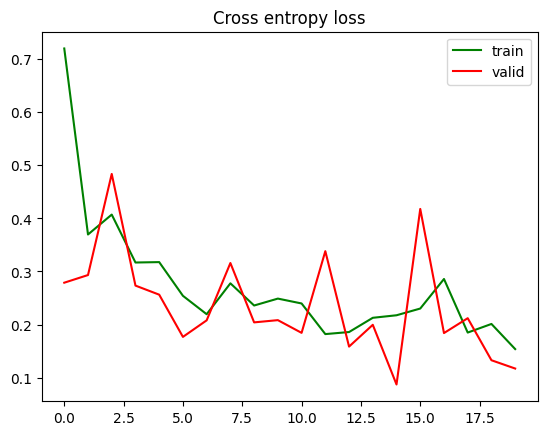

In [21]:
LEARNING_RATE = 0.001
EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optimzer = optim.Adam(vgg16.classifier.parameters(), lr=LEARNING_RATE)

train(vgg16, train_loader, val_loader, criterion, optimzer, device, EPOCHS)

In [26]:
result = test(vgg16, val_loader, device)

              precision    recall  f1-score   support

 Brain Tumor     0.9832    0.9412    0.9617       187
     Healthy     0.9286    0.9795    0.9533       146

    accuracy                         0.9580       333
   macro avg     0.9559    0.9603    0.9575       333
weighted avg     0.9593    0.9580    0.9581       333



Train loss: 0.059437
Valid. loss: 0.188713



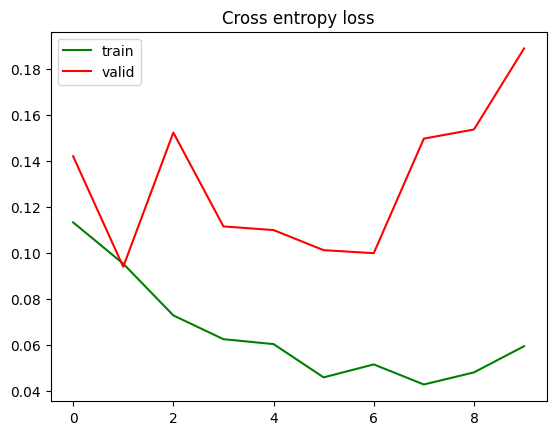

In [28]:
LEARNING_RATE = 0.0001
EPOCHS = 10
optimzer = optim.Adam(vgg16.classifier.parameters(), lr=LEARNING_RATE)

train(vgg16, train_loader, val_loader, criterion, optimzer, device, EPOCHS)

In [29]:
result = test(vgg16, val_loader, device)

              precision    recall  f1-score   support

 Brain Tumor     0.9735    0.9840    0.9787       187
     Healthy     0.9792    0.9658    0.9724       146

    accuracy                         0.9760       333
   macro avg     0.9764    0.9749    0.9756       333
weighted avg     0.9760    0.9760    0.9760       333



In [30]:
torch.save(vgg16.state_dict(), 'pre_trained.vgg')

In [32]:
for name, param in vgg16.named_parameters():
    print(f"{name} is {'not ' if param.requires_grad else ''}frozen")

features.0.weight is frozen
features.0.bias is frozen
features.2.weight is frozen
features.2.bias is frozen
features.5.weight is frozen
features.5.bias is frozen
features.7.weight is frozen
features.7.bias is frozen
features.10.weight is frozen
features.10.bias is frozen
features.12.weight is frozen
features.12.bias is frozen
features.14.weight is frozen
features.14.bias is frozen
features.17.weight is frozen
features.17.bias is frozen
features.19.weight is frozen
features.19.bias is frozen
features.21.weight is frozen
features.21.bias is frozen
features.24.weight is frozen
features.24.bias is frozen
features.26.weight is frozen
features.26.bias is frozen
features.28.weight is frozen
features.28.bias is frozen
classifier.0.weight is not frozen
classifier.0.bias is not frozen
classifier.3.weight is not frozen
classifier.3.bias is not frozen
classifier.6.weight is not frozen
classifier.6.bias is not frozen


In [33]:
for param in vgg16.features.parameters():
    param.requires_grad = True

for param in vgg16.classifier.parameters():
    param.requires_grad = False

In [34]:
for name, param in vgg16.named_parameters():
    print(f"{name} is {'not ' if param.requires_grad else ''}frozen")

features.0.weight is not frozen
features.0.bias is not frozen
features.2.weight is not frozen
features.2.bias is not frozen
features.5.weight is not frozen
features.5.bias is not frozen
features.7.weight is not frozen
features.7.bias is not frozen
features.10.weight is not frozen
features.10.bias is not frozen
features.12.weight is not frozen
features.12.bias is not frozen
features.14.weight is not frozen
features.14.bias is not frozen
features.17.weight is not frozen
features.17.bias is not frozen
features.19.weight is not frozen
features.19.bias is not frozen
features.21.weight is not frozen
features.21.bias is not frozen
features.24.weight is not frozen
features.24.bias is not frozen
features.26.weight is not frozen
features.26.bias is not frozen
features.28.weight is not frozen
features.28.bias is not frozen
classifier.0.weight is frozen
classifier.0.bias is frozen
classifier.3.weight is frozen
classifier.3.bias is frozen
classifier.6.weight is frozen
classifier.6.bias is frozen


Train loss: 0.46795
Valid. loss: 0.436534



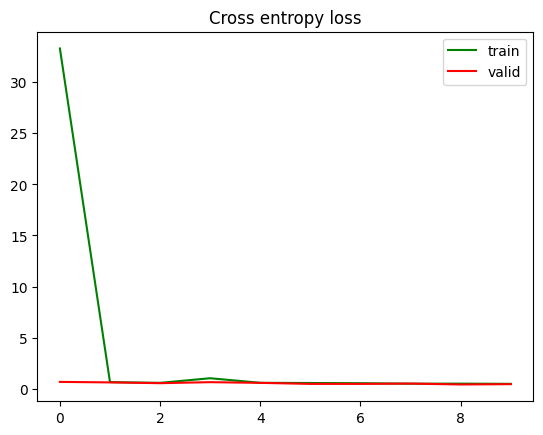

In [36]:
LEARNING_RATE = 0.001
EPOCHS = 10
optimzer = optim.Adam(vgg16.features.parameters(), lr=LEARNING_RATE)

train(vgg16, train_loader, val_loader, criterion, optimzer, device, EPOCHS)

In [37]:
result = test(vgg16, val_loader, device)

              precision    recall  f1-score   support

 Brain Tumor     0.7544    0.9198    0.8289       187
     Healthy     0.8571    0.6164    0.7171       146

    accuracy                         0.7868       333
   macro avg     0.8058    0.7681    0.7730       333
weighted avg     0.7994    0.7868    0.7799       333



In [39]:
# Load the VGG16 model
vgg16 = models.vgg16(pretrained=True)

vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

# Load the state dictionary into the model
vgg16.load_state_dict(torch.load('pre_trained.vgg'))
vgg16 = vgg16.to(device)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
result = test(vgg16, val_loader, device)

              precision    recall  f1-score   support

 Brain Tumor     0.9787    0.9840    0.9813       187
     Healthy     0.9793    0.9726    0.9759       146

    accuracy                         0.9790       333
   macro avg     0.9790    0.9783    0.9786       333
weighted avg     0.9790    0.9790    0.9790       333



In [41]:
def test_plot(model, dataset, device):
    all_probs = []
    all_preds = []
    all_targets = []
    wrong_preds = []

    total_corrects = 0
    total_n = 0
    model.eval()
    for instances, labels in dataset:
        instances = instances.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(instances)
            probabilities = nn.functional.softmax(logits, 1)
            preds = torch.argmax(probabilities, 1)

        corrects = preds == labels
        incorrect_indices = ~corrects

        total_corrects += corrects.sum().item()
        total_n += len(instances)

        all_probs.append(probabilities.cpu())
        all_preds.append(preds.unsqueeze(-1))
        all_targets.append(labels.cpu())

        # salvando as imagens erradas para mostrá-las posteriormente
        for idx in incorrect_indices.nonzero(as_tuple=True)[0]:
            img = instances[idx].cpu()
            pred_label = preds[idx].item()
            true_label = labels [idx].item()
            wrong_preds.append((img, pred_label, true_label))

    preds = torch.cat(all_preds).cpu()
    targets = torch.cat(all_targets).cpu()

    return (preds, targets, wrong_preds)

In [45]:
all_preds, all_targets, wrong_preds = test_plot(vgg16, test_loader, device)

In [46]:
len(wrong_preds)

14

In [48]:
print(classification_report(all_targets, all_preds, target_names=class_names, zero_division=0, digits=4))

              precision    recall  f1-score   support

 Brain Tumor     0.9600    0.9697    0.9648       198
     Healthy     0.9549    0.9407    0.9478       135

    accuracy                         0.9580       333
   macro avg     0.9574    0.9552    0.9563       333
weighted avg     0.9579    0.9580    0.9579       333



In [50]:
class_names

['Brain Tumor', 'Healthy']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

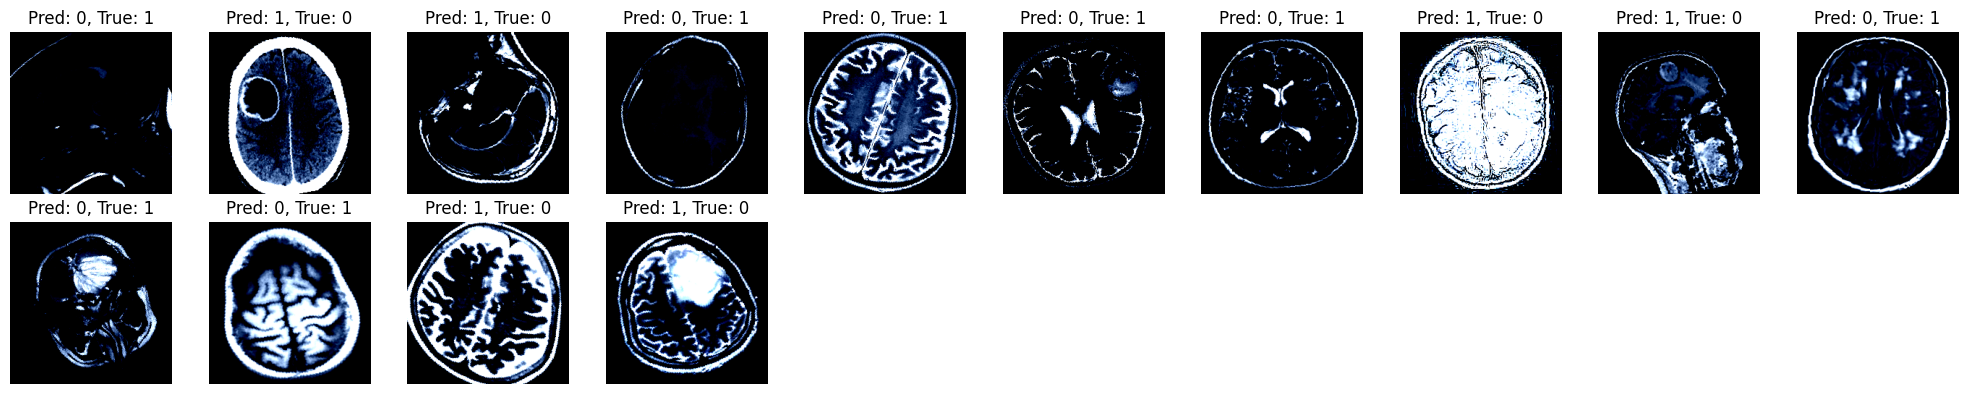

In [49]:
def plot_wrong_predictions(wrong_preds, num_images=30):
    num_images = min(num_images, len(wrong_preds))
    num_cols = 10
    num_rows = (num_images + num_cols - 1) // num_cols  # Compute the number of rows needed

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 2))
    axes = axes.flatten()

    for i in range(num_images):
        img, pred, true = wrong_preds[i]
        ax = axes[i]

        # Transpose image if it's in (channels, height, width) format
        if img.shape[0] == 3:  # Check if the image has 3 channels
            img = img.permute(1, 2, 0)

        ax.imshow(img, cmap='gray' if img.shape[-1] == 1 else None)
        ax.set_title(f"Pred: {pred}, True: {true}")
        ax.axis('off')

    # Hide any unused axes if there are less than num_images wrong predictions
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display wrong predictions
plot_wrong_predictions(wrong_preds)

In [ ]:
vgg16 = models.vgg16(pretrained=True)

# adapting the output layer so it maches the amount of classes
print(vgg16.classifier[6])
num_classes = len(class_names)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)
print(vgg16.classifier[6])

vgg16 = vgg16.to(device)

In [ ]:
for param in vgg16.features.parameters():
    param.requires_grad = False